<a href="https://colab.research.google.com/github/choarauc/form_ch/blob/main/Copie_de_SQL_avanc%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

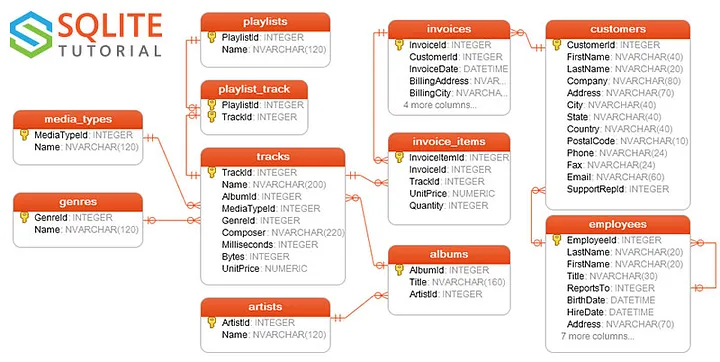

### Lancer les 4 cellules au préalable 

In [ ]:
#@title
import urllib.request
import zipfile
from functools import partial
import os

chinook_url = 'http://www.sqlitetutorial.net/wp-content/uploads/2018/03/chinook.zip'
if not os.path.exists('chinook.zip'):
    print('downloading chinook.zip ', end='')
    with urllib.request.urlopen(chinook_url) as response:
        with open('chinook.zip', 'wb') as f:
            for data in iter(partial(response.read, 4*1024), b''):
                print('.', end='', flush=True)
                f.write(data)

zipfile.ZipFile('chinook.zip').extractall()
assert os.path.exists('chinook.db')

downloading chinook.zip ...........................................................................

In [ ]:
#@title
from IPython.display import display
import pandas as pd

def sql(query):
    print()
    print(query)
    print()


def get_results(query):
    global engine
    q = query.statement if isinstance(query, sqlalchemy.orm.query.Query) else query
    return pd.read_sql(q, engine)


def display_results(query):
    df = get_results(query)
    display(df)
    sql(query)

In [ ]:
#@title
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
import sqlite3
engine = create_engine('sqlite:///chinook.db')
cur = engine.connect()
def SQL(script):
  global cur
  return pd.read_sql(script,cur)

In [ ]:
#@title
metadata = sqlalchemy.MetaData()
metadata.reflect(engine)

from sqlalchemy.ext.automap import automap_base

Base = automap_base(metadata=metadata)

Base.prepare()

from sqlalchemy.orm import sessionmaker
Session = sessionmaker(bind=engine)
session = Session()

## Explorer la BD

### Informations

+ afficher le nom des tables :

In [ ]:
engine.table_names()

<ipython-input-5-d72bc75a6b62>:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  engine.table_names()


['albums',
 'artists',
 'customers',
 'employees',
 'genres',
 'invoice_items',
 'invoices',
 'media_types',
 'playlist_track',
 'playlists',
 'sqlite_sequence',
 'sqlite_stat1',
 'tracks']

In [ ]:
#Script à copier et à remplir pour répondre au questions :
SQL("""
--Vous pouvez écrire votre requette SQL ici :
SELECT * FROM tracks
 """)

### Exercices

#### Quels sont les **5** genres les plus représentés ?

In [ ]:
#@title
SQL("""
SELECT genres.Name as genre ,count(*) as nbr_tracks
FROM tracks
LEFT JOIN genres
USING (GenreId)
GROUP BY GenreId
ORDER BY nbr_tracks DESC
LIMIT 5;
 """)

#### Quels sont les artistes qui ont vendu le plus de titres ?

In [ ]:
#@title
SQL("""

SELECT artists.Name, count(*) 
FROM invoice_items
LEFT JOIN tracks
USING (TrackID)
LEFT JOIN albums
USING (AlbumId)
LEFT JOIN artists
USING (ArtistID)
GROUP BY 1
ORDER BY 2 DESC

 """)

,Name,count(*)
0,Iron Maiden,140
1,U2,107
2,Metallica,91
3,Led Zeppelin,87
4,Os Paralamas Do Sucesso,45
...,...,...
160,Berliner Philharmoniker & Hans Rosbaud,1
161,Antal Doráti & London Symphony Orchestra,1
162,Adrian Leaper & Doreen de Feis,1
163,"Academy of St. Martin in the Fields, John Birc...",1


#### Quels sont les **10** artistes qui ont fait le plus de morceaux ? ( Affiche également leur nombre de morceaux )



In [ ]:
#@title
SQL("""
SELECT artists.Name, count(*) as nbr_tracks
FROM artists 
LEFT JOIN albums
USING (ArtistID)
LEFT JOIN tracks
USING (AlbumID)
GROUP BY artists.Name
ORDER BY nbr_tracks DESC
LIMIT 10;
""")

,Name,nbr_tracks
0,Iron Maiden,213
1,U2,135
2,Led Zeppelin,114
3,Metallica,112
4,Lost,92
5,Deep Purple,92
6,Pearl Jam,67
7,Lenny Kravitz,57
8,Various Artists,56
9,The Office,53


#### Quelle est la moyenne du nombre de morceaux sorti par artistes ? ( arrondis à l'unité )

In [ ]:
# sélection des données -> ici le résultat est le nombre moyen de pistes par artiste arrondi. 
# La fonction "round" arrondie le résultat de la fonction "AVG", qui est la moyenne des pistes par artiste.
# On renomme le résultat avec AS

SQL("""
SELECT round(AVG(nbr_tracks)) as average_track_per_artitst

## nous spécifions les tables que nous utilisons dans notre requête.
FROM 

## sous-requête qui sélectionne les noms d'artistes et le nombre total de pistes pour chaque artiste. 
    (SELECT artists.Name, count(*) as nbr_tracks
      FROM artists 

## jointure entre les tables "artists", "albums" et "tracks". 
## "USING" pour spécifier la colonne qui est utilisée pour la jointure.

      LEFT JOIN albums
      USING (ArtistID)
      LEFT JOIN tracks
      USING (AlbumID)

## "GROUP BY" pour regrouper les résultats par nom d'artiste.
      GROUP BY artists.Name)
 """)

# 1 : cette requête sélectionne le nombre moyen de pistes / artiste 
# 2 : et sous-requête pour sélectionner les noms d'artistes et le nombre total de pistes pour chaque artiste 
# 3 : puis calcule la moyenne de ces nombres et arrondit le résultat

#### On utilise une sous-requête ici car le nombre total de pistes / artiste ne peut pas être directement obtenu à partir d'une seule table 

_________

## Alternative 1 sans le using

SELECT ROUND(AVG(track_count)) AS average_track_per_artist
FROM (
  SELECT artists.Name, COUNT(*) AS track_count
  FROM artists 
  JOIN albums ON artists.ArtistID = albums.ArtistID
  JOIN tracks ON albums.AlbumID = tracks.AlbumID
  GROUP BY artists.ArtistID
) artist_track_counts

__________


# Alternative 2 avec une sous requete plus simple 
# on elle utilise une seule jointure au lieu de 2 et une sous-requête uniquement pour calculer le nombre de pistes / album

SELECT ROUND(AVG(track_count)) AS average_track_per_artist
FROM artists 
JOIN albums ON artists.ArtistID = albums.ArtistID
JOIN (
  SELECT AlbumID, COUNT(*) AS track_count
  FROM tracks 
  GROUP BY AlbumID
) album_track_counts ON albums.AlbumID = album_track_counts.AlbumID
GROUP BY artists.ArtistID


,average_track_per_artitst
0,13.0


#### Qui sont les artistes qui ont sorti plus de morceaux que la moyenne ?

In [ ]:
#@title
SQL(
    """
SELECT artists.Name, count(*) as nbr_tracks
FROM artists 
LEFT JOIN albums
USING (ArtistID)
LEFT JOIN tracks
USING (AlbumID)
GROUP BY artists.Name
HAVING nbr_tracks > ( SELECT round(AVG(nbr_tracks))
                      FROM(
                            SELECT artists.Name, count(*) as nbr_tracks
                            FROM artists 
                            LEFT JOIN albums
                            USING (ArtistID)
                            LEFT JOIN tracks
                            USING (AlbumID)
                            GROUP BY artists.Name
                          )
                          )
ORDER BY nbr_tracks DESC
 """)

,Name,nbr_tracks
0,Iron Maiden,213
1,U2,135
2,Led Zeppelin,114
3,Metallica,112
4,Lost,92
...,...,...
88,Gonzaguinha,14
89,Falamansa,14
90,Elis Regina,14
91,Ed Motta,14
